In [1]:
import os
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns 
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

In [2]:
os.chdir("/Volumes/TwoTeras/")

## Creation of map data session segregated

In [3]:
data_frame = pd.read_csv("/Volumes/TwoTeras/1_Experiment_2/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV.cvs")
data_frame1 = pd.read_csv("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/Complete_Data_AngularV.cvs")

In [4]:
# Function to process the data frame
def process_data(df):
    # Select and rename columns
    processed_df = df[["SubjectID", "Session", "SessionSubsection", "timeStampDataPointEnd", 
                       "playerBodyPosition.x", "playerBodyPosition.z"]].copy()
    # Round coordinates
    processed_df['playerBodyPosition_X_Rounded'] = processed_df['playerBodyPosition.x'].round(1)
    processed_df['playerBodyPosition_Z_Rounded'] = processed_df['playerBodyPosition.z'].round(1)
    processed_df['timeformat'] = pd.to_datetime(processed_df['timeStampDataPointEnd'], unit='s')
    return processed_df

# Assuming data_frame and data_frame1 are your original data frames
Map_data = process_data(data_frame)
Map_data1 = process_data(data_frame1)

# Concatenate the two data frames
concatenated_data = pd.concat([Map_data, Map_data1], ignore_index=True)

In [5]:
Map_data1.head()

,SubjectID,Session,SessionSubsection,timeStampDataPointEnd,playerBodyPosition.x,playerBodyPosition.z,playerBodyPosition_X_Rounded,playerBodyPosition_Z_Rounded,timeformat
0,479,2,1,1.653045e+09,-59.099869,34.795731,-59.1,34.8,2022-05-20 11:17:02.206556928
1,479,2,1,1.653045e+09,-59.099869,34.795731,-59.1,34.8,2022-05-20 11:17:02.213004288
2,479,2,1,1.653045e+09,-59.099869,34.795731,-59.1,34.8,2022-05-20 11:17:02.224909056
3,479,2,1,1.653045e+09,-59.099869,34.795731,-59.1,34.8,2022-05-20 11:17:02.236317184
4,479,2,1,1.653045e+09,-59.099869,34.795731,-59.1,34.8,2022-05-20 11:17:02.258141696


In [6]:
# Define a function for resampling within each group
def resample_group(group):
    resampled = group.resample('1S', on='timeformat').first()
    return resampled.reset_index()  # Resetting the index here

# Group by Participant ID, Session, and SessionSubsection, and apply the resampling function
# The 'group_keys=False' prevents the group keys from becoming an index
resampled_data = concatenated_data.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(resample_group)
resampled_data1 = Map_data1.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(resample_group)
resampled_data2 = Map_data.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(resample_group)

# Drop rows where either of the specified columns is NaN
resampled_data = resampled_data.dropna(subset=['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded'])
resampled_data1 = resampled_data1.dropna(subset=['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded'])
resampled_data2 = resampled_data2.dropna(subset=['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded'])

# Define a function to remove the first two seconds of each session for each group
def remove_first_two_seconds(group):
    group = group.sort_values(by='timeformat')
    start_time = group['timeformat'].iloc[0]
    two_seconds_later = start_time + pd.Timedelta(seconds=2)
    return group[group['timeformat'] > two_seconds_later]

# Apply the remove_first_two_seconds function with group_keys=False
resampled_data_2S = resampled_data.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(remove_first_two_seconds)
resampled_data_2S1 = resampled_data1.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(remove_first_two_seconds)
resampled_data_2S2 = resampled_data2.groupby(["SubjectID", "Session", "SessionSubsection"], group_keys=False).apply(remove_first_two_seconds)
# Select only the rounded position columns and drop rows with NaN values
final_data = resampled_data_2S[['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded']].dropna()
final_data1 = resampled_data_2S1[['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded']].dropna()
final_data2 = resampled_data_2S1[['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded']].dropna()

# Display the first few rows of the final data
final_data.head()


,playerBodyPosition_Z_Rounded,playerBodyPosition_X_Rounded
3,34.8,-59.1
4,34.8,-59.1
5,34.8,-59.1
6,34.8,-59.1
7,34.8,-59.1


In [7]:
def create_palette(colormap_name, indices):
    try:
        colormap = plt.get_cmap(colormap_name)
        palette = colormap(indices)
        return palette
    except ValueError:
        print(f"Colormap '{colormap_name}' is not found.")
        return None

def display_palette(palette, title):
    if palette is not None:
        sns.palplot(palette)
        plt.title(title)
    else:
        print(f"Palette for '{title}' could not be displayed.")

num_colors = 200
color_indices = np.linspace(0, 1, num_colors)
selected_indices = list(range(0, 200, 5))

# Dictionary to store palettes
palettes = {}

# Create palettes for each colormap
for colormap_name in ['cmc.roma']:
    palettes[colormap_name] = create_palette(colormap_name, color_indices[selected_indices])

# Optional: Display the palettes
for name, palette in palettes.items():
    display_palette(palette, name)

plt.show()

Colormap 'cmc.roma' is not found.
Palette for 'cmc.roma' could not be displayed.


In [ ]:
def plot_heatmap(data, ax, title):
    hb = ax.hexbin(data['playerBodyPosition_X_Rounded'], data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cividis', vmin=1, vmax=300)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return hb


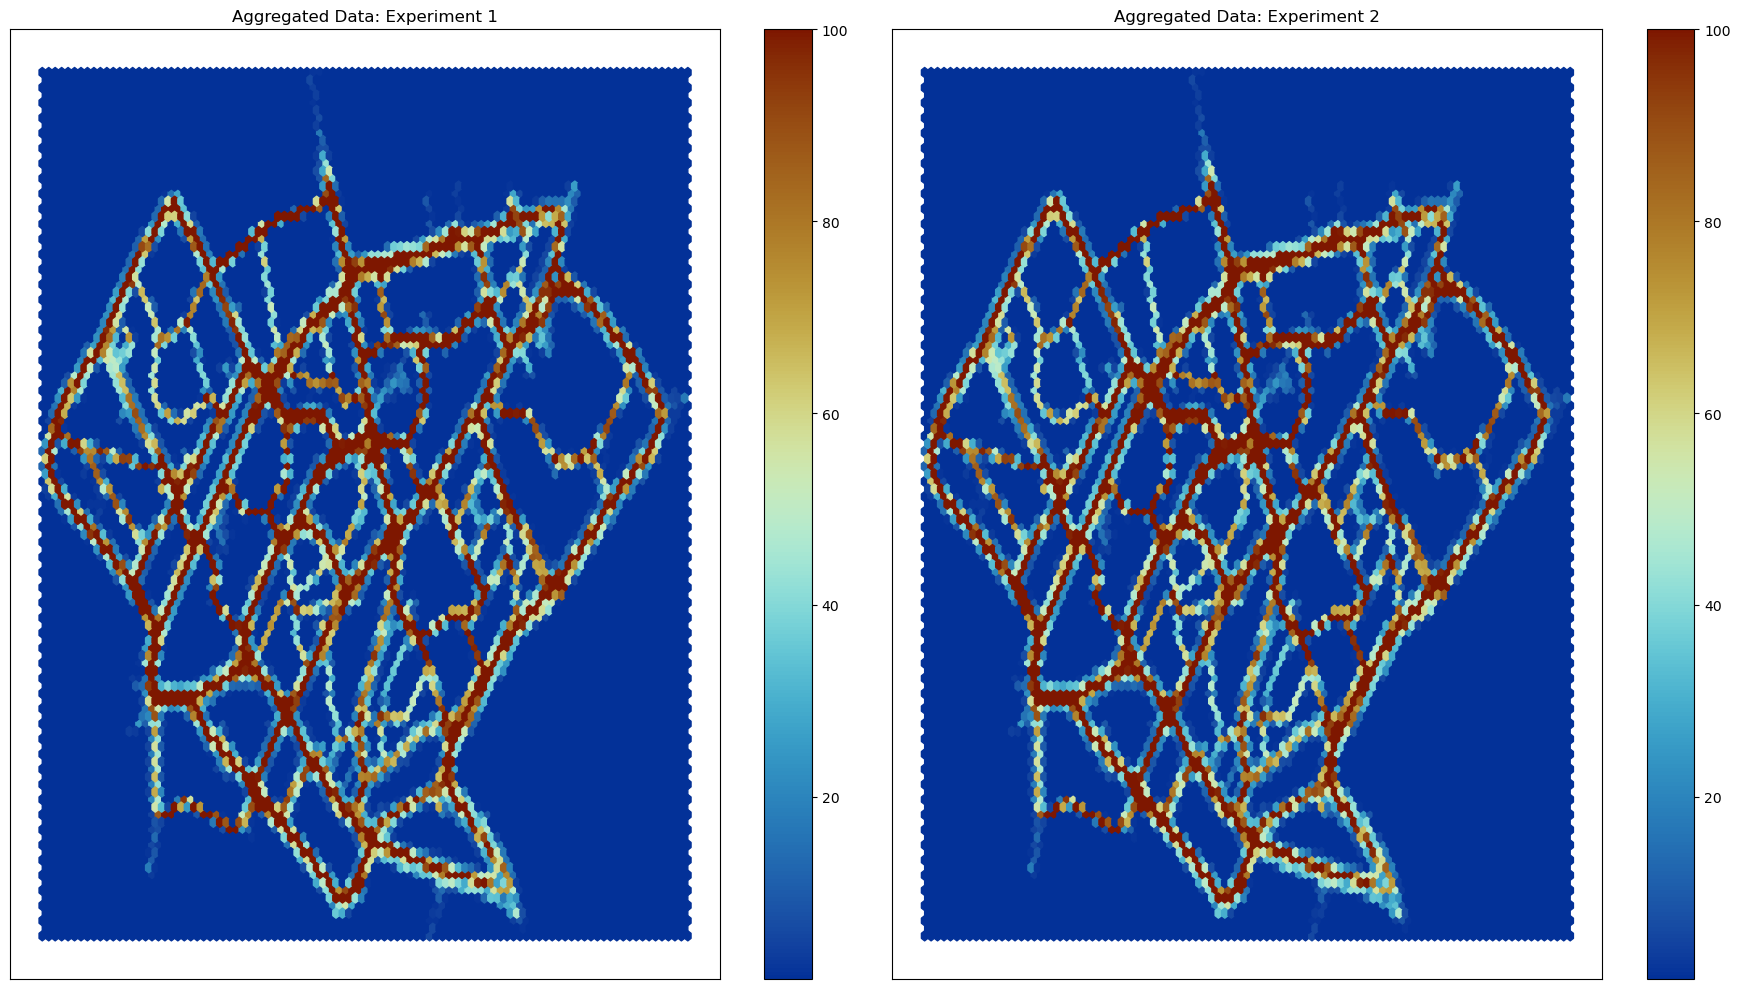

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import cmcrameri.cm as cmc

def expand_data(data):
    freq_table = data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')
    freq_table['count'] = freq_table['count'].clip(upper=max_visits)
    return freq_table.loc[freq_table.index.repeat(freq_table['count'])]

def plot_heatmap(data, ax, title):
    hb = ax.hexbin(data['playerBodyPosition_X_Rounded'], data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cmc.roma_r', vmin=1, vmax=100)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    return hb
max_visits = 1  #  cap as needed

# Expanding data for heatmap
expanded_exp1_data = expand_data(final_data1)
expanded_exp2_data = expand_data(final_data2)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(18, 10), facecolor='white')
hb1 = plot_heatmap(expanded_exp1_data, axs[0], 'Aggregated Data: Experiment 1')
hb2 = plot_heatmap(expanded_exp2_data, axs[1], 'Aggregated Data: Experiment 2')

# Adjusting colorbar to be consistent across both plots
fig.colorbar(hb1, ax=axs[0], orientation='vertical')
fig.colorbar(hb2, ax=axs[1], orientation='vertical')

plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Two_Experiments_AggregatedSessions.png", pad_inches=0.3)
plt.show()


In [ ]:
expanded_exp1_data.head()

,playerBodyPosition_X_Rounded,playerBodyPosition_Z_Rounded,count
0,-442.9,39.4,1
1,-441.8,39.2,1
2,-441.8,42.5,1
3,-441.6,37.4,1
4,-441.5,38.6,1


In [ ]:
expanded_exp2_data.head()

,playerBodyPosition_X_Rounded,playerBodyPosition_Z_Rounded,count
0,-442.9,39.4,1
1,-441.8,39.2,1
2,-441.8,42.5,1
3,-441.6,37.4,1
4,-441.5,38.6,1


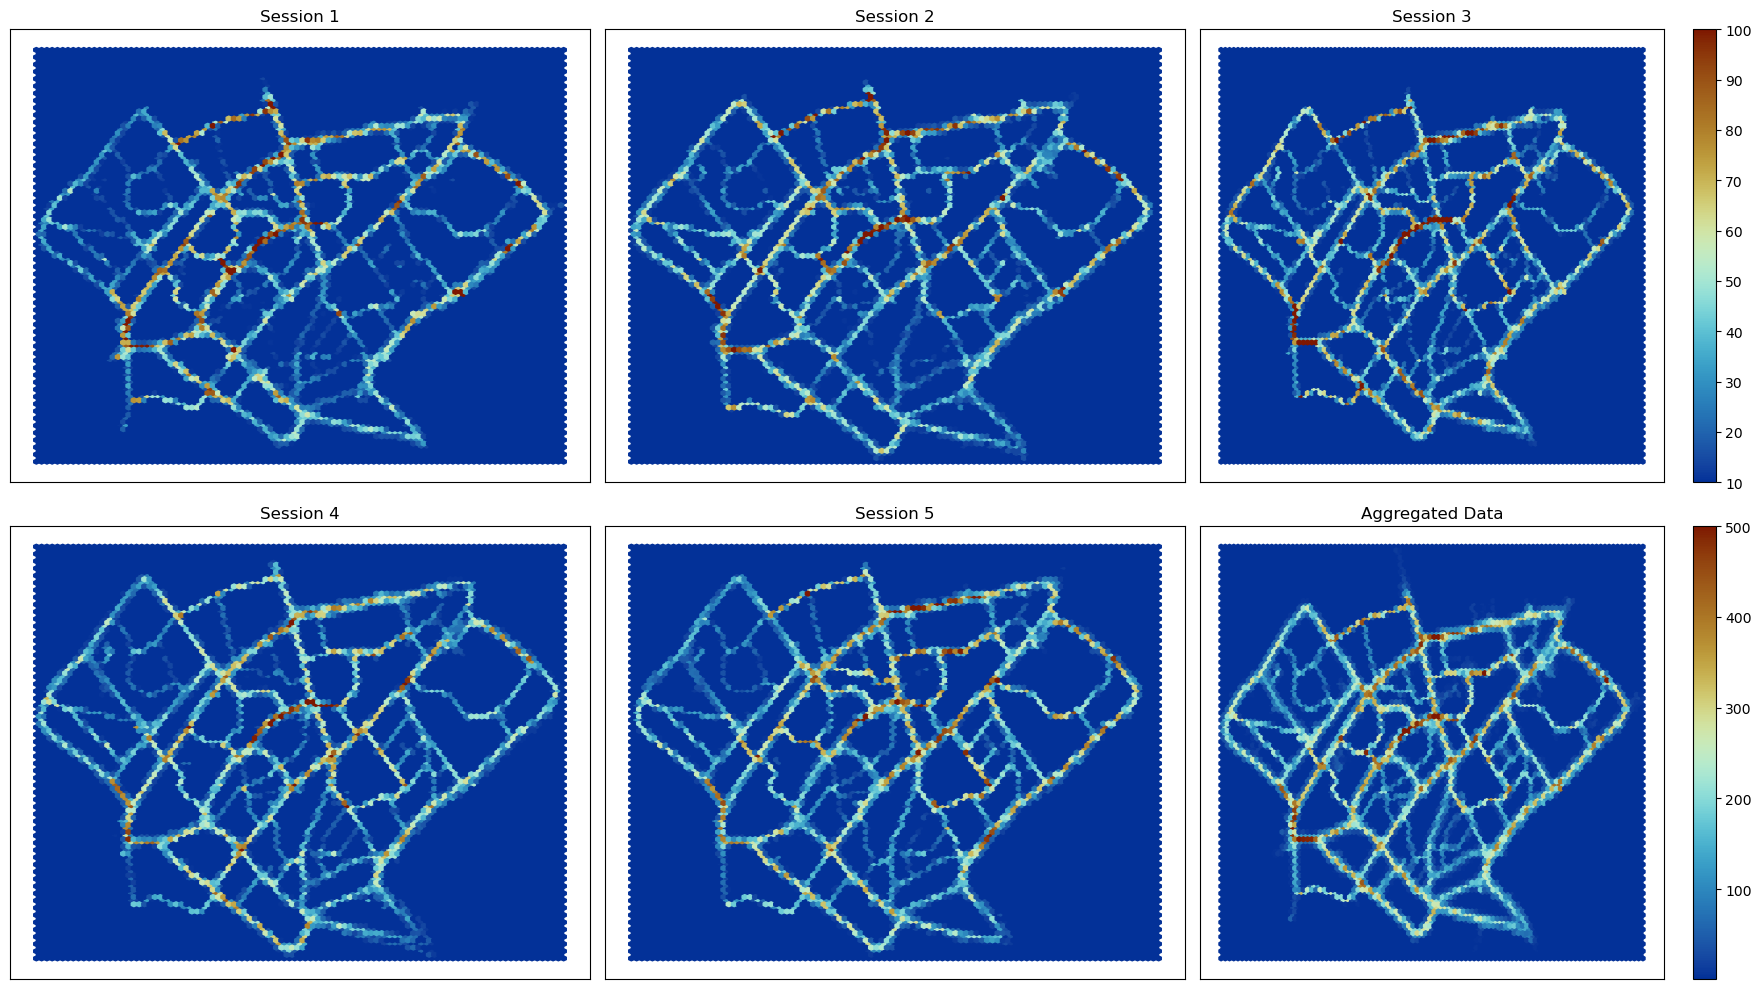

In [ ]:
# Identify unique sessions
unique_sessions = resampled_data_2S['Session'].astype(int).unique()

# Define the maximum number of visits per location
max_visits = 1  #  cap as needed

# Create a grid of subplots - 3 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(18, 10), facecolor='white')  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array for easy indexing

# Iterate over sessions and create a heatmap for each
for i, session in enumerate(unique_sessions):
    # Filter data for the current session
    session_data = resampled_data_2S[resampled_data_2S['Session'] == session]

    # Create a frequency table
    freq_table = session_data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')

    # Cap the frequencies
    freq_table['count'] = freq_table['count'].clip(upper=max_visits)

    # Expand the data based on capped frequencies
    expanded_data = freq_table.loc[freq_table.index.repeat(freq_table['count'])]

    # Create the heatmap with adjusted data in the ith subplot
    ax = axs[i]
    hb = ax.hexbin(expanded_data['playerBodyPosition_X_Rounded'], expanded_data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cmc.roma_r', vmin=10, vmax=100)
    ax.set_title(f'Session {session}')
     # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    if i in [2]:
        fig.colorbar(hb, ax=ax, orientation='vertical')
    

# Aggregate heatmap for all sessions in the sixth plot
all_data = resampled_data_2S
all_freq_table = all_data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')
all_freq_table['count'] = all_freq_table['count'].clip(upper=max_visits)
expanded_all_data = all_freq_table.loc[all_freq_table.index.repeat(all_freq_table['count'])]
ax = axs[5]  # Sixth subplot
hb_all = ax.hexbin(expanded_all_data['playerBodyPosition_X_Rounded'], expanded_all_data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cmc.roma_r', vmin=1, vmax=500)
ax.set_title('Aggregated Data')
# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(hb_all, ax=ax, orientation='vertical')
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Participants_Exploration_Sessions.png",  bbox_inches="tight",
            pad_inches=0.3)
plt.show()

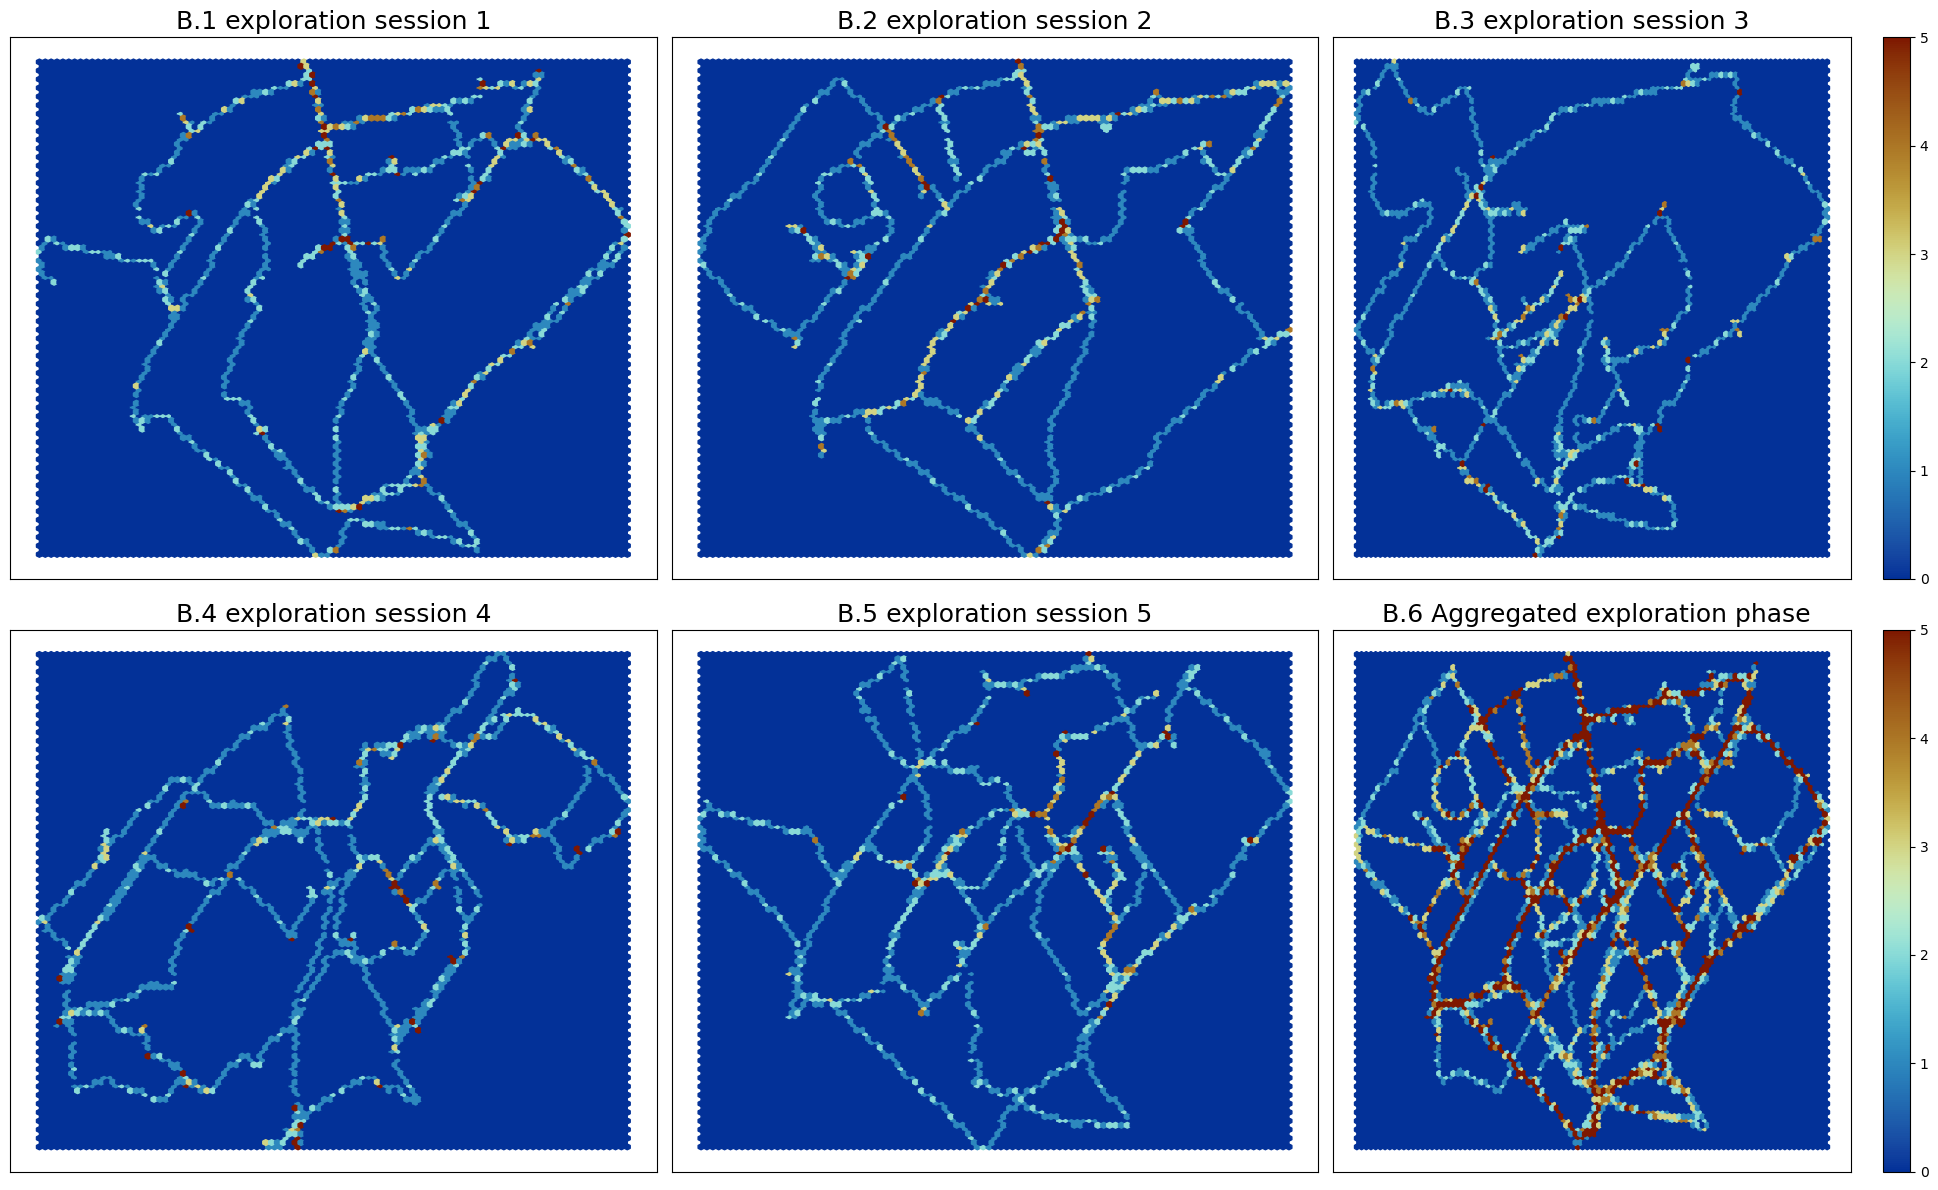

In [ ]:
# Identify unique sessions
One_Subject = resampled_data_2S[resampled_data_2S.SubjectID == 1031]
unique_sessions = One_Subject['Session'].astype(int).unique()

# Define the maximum number of visits per location
max_visits = 1  #  cap as needed

# Create a grid of subplots - 3 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(20, 12),  facecolor='white')  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array for easy indexing

# Iterate over sessions and create a heatmap for each
for i, session in enumerate(unique_sessions):
    # Filter data for the current session
    session_data = One_Subject[One_Subject['Session'] == session]

    # Create a frequency table
    freq_table = session_data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')

    # Cap the frequencies
    freq_table['count'] = freq_table['count'].clip(upper=max_visits)

    # Expand the data based on capped frequencies
    expanded_data = freq_table.loc[freq_table.index.repeat(freq_table['count'])]

    # Create the heatmap with adjusted data in the ith subplot
    ax = axs[i]
    hb = ax.hexbin(expanded_data['playerBodyPosition_X_Rounded'], expanded_data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cmc.roma_r', vmin=0, vmax=5)
    ax.set_title(f'B.{session} exploration session {session}',  fontsize=18)
     # Remove x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    if i in [2]:
        fig.colorbar(hb, ax=ax, orientation='vertical')
        
    

# Aggregate heatmap for all sessions in the sixth plot
all_data = One_Subject
all_freq_table = all_data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')
all_freq_table['count'] = all_freq_table['count'].clip(upper=max_visits)
expanded_all_data = all_freq_table.loc[all_freq_table.index.repeat(all_freq_table['count'])]
ax = axs[5]  # Sixth subplot
hb_all = ax.hexbin(expanded_all_data['playerBodyPosition_X_Rounded'], expanded_all_data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='cmc.roma_r', vmin=0, vmax=5)
ax.set_title(' B.6 Aggregated exploration phase',  fontsize=18)
# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(hb_all, ax=ax, orientation='vertical')
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/One_Participant_Exploration_Sessions.png",  bbox_inches="tight",
            pad_inches=0.3)
plt.show()

In [ ]:
unique_sessions + 2

array([3, 4, 5, 6, 7])

In [ ]:
Coverage =  pd.read_csv('/Volumes/TwoTeras/Graph_Stuff/CSVs/Unique_NodeVisit_Ratios.csv')

NameError: name 'custom_palette' is not defined

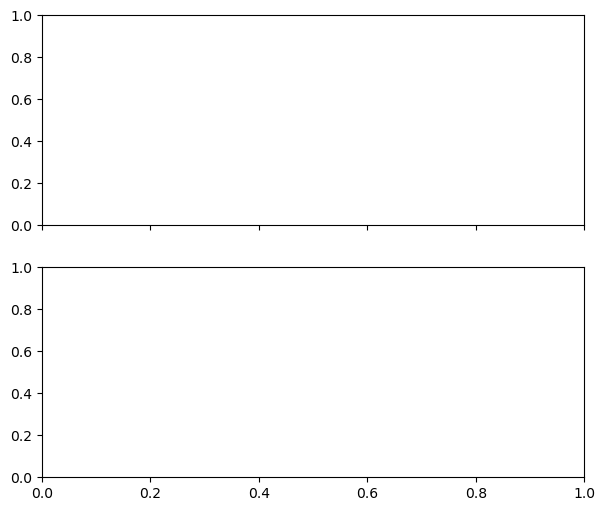

In [ ]:
# Assuming df_total_new is pre-loaded and contains the necessary columns
hex_codes = palettes['cmc.roma']

# Filter out the control group for plotting
filtered_df = Coverage[Coverage['Experiment'] != 'control']

# Create a custom palette
#custom_palette =  hex_codes[[39, -10, -17 ,-30, -40]]

# Set up the matplotlib figure with 2 subplots
fig, axes = plt.subplots(2, 1, figsize=(7, 6), sharex=True)  # Adjusted figure size for better layout

# KDE plot for IndividualRatio
sns.kdeplot(data=filtered_df, x='IndividualRatio', hue='SessionNr', palette=custom_palette, ax=axes[0])
axes[0].set_xlabel('Ratio of Visited Nodes/Total Nodes Over One Session')
axes[0].set_ylabel('Density Distribution')
axes[0].set_title('A.1) Density plot of individual session ratios of map coverage')

# KDE plot for CummulativeRatio
sns.kdeplot(data=filtered_df, x='CummulativeRatio', hue='SessionNr', palette=custom_palette, ax=axes[1])
axes[1].set_xlabel('Cumulative Ratio of Visited Nodes/Total Nodes')
axes[1].set_ylabel('Density Distribution')
axes[1].set_title('A.2) Density Plot of cumulative ratio of map coverage')

# Adjust legend
axes[0].legend([])

# Improve the layout
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Coverage_Ratios.png",  bbox_inches="tight",
            pad_inches=0.3)
plt.show()


In [ ]:
oneSub_OneSes = resampled_data_2S[(resampled_data_2S.SubjectID == 1031) & (resampled_data_2S.Session == 1)]
one_freq_table = oneSub_OneSes.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')
one_freq_table['count'] = one_freq_table['count'].clip(upper=max_visits)
expanded_one_data = one_freq_table.loc[one_freq_table.index.repeat(one_freq_table['count'])]
expanded_one_data.head()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 10), facecolor='white')  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array for easy indexing
ax = axs[0]  # Sixth subplot
hb_all = ax.hexbin(expanded_one_data['playerBodyPosition_X_Rounded'], expanded_one_data['playerBodyPosition_Z_Rounded'], gridsize=100, cmap='viridis', vmin=1, vmax=5)
ax.set_title('First exploration of one subject in the city')
# Remove x and y ticks
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(hb_all, ax=ax, orientation='vertical')
plt.tight_layout()
plt.show()



In [ ]:
# Assuming final_data contains your data
x = final_data['playerBodyPosition_X_Rounded']
y = final_data['playerBodyPosition_Z_Rounded']

# Create a frequency table
freq_table = final_data.groupby(['playerBodyPosition_X_Rounded', 'playerBodyPosition_Z_Rounded']).size().reset_index(name='count')

# Cap the frequencies
max_visits =1 # Set your cap value here
freq_table['count'] = freq_table['count'].clip(upper=max_visits)

# Expand the data based on capped frequencies
expanded_data = freq_table.loc[freq_table.index.repeat(freq_table['count'])]

# Create the heat map with adjusted data
plt.hexbin(expanded_data['playerBodyPosition_X_Rounded'], expanded_data['playerBodyPosition_Z_Rounded'], gridsize=70, cmap='viridis')
plt.colorbar(label='Density')
plt.show()

In [ ]:
sns.scatterplot(x=x, y=y, alpha=0.1)

In [ ]:
Map_data.to_csv('/Users/tracysanchezpacheco/Desktop/Map_data.csv', index=False)

In [ ]:
# Filter data by session and save to separate CSV files
unique_sessions = resampled_data['Session'].unique()
for session in unique_sessions:
    session_data = Map_data[Map_data['Session'] == session].copy()
    output_file = f'/Volumes/TwoTeras/Maps/Resample/session_{session}.csv'
    session_data.to_csv(output_file, index=False)

In [ ]:
# Extract the rounded X and Z coordinates

heat_data = resampled_data[['playerBodyPosition_Z_Rounded', 'playerBodyPosition_X_Rounded']].values.tolist()

# Create a Folium map
# The location is set to the first coordinate in the data for centering the map
map_center = [heat_data[0][0], heat_data[0][1]]
map = folium.Map(location=map_center, zoom_start=15)

# Add a HeatMap layer
HeatMap(heat_data).add_to(map)

# Save the map to an HTML file
map_file_path = '/Users/tracysanchezpacheco/Desktop/player_heatmap.html'  # Replace with your desired output path
map.save(map_file_path)